In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import interpolate

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

512


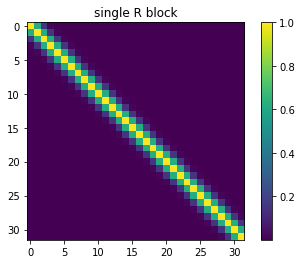

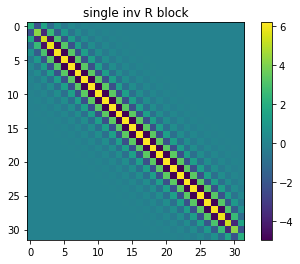

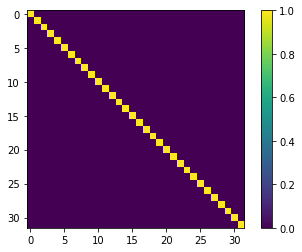

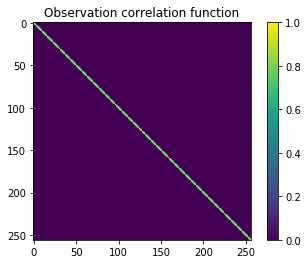

In [5]:
dimension = 2**9
print(dimension)
# rho0_l = 0.09
# rho0_s = 0.003

rho0_l = 0.2
rho0_m = 0.02
rho0_s = 0.002
# rho0 = 0.2
# dx = 0.25
dx = 1/dimension

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

H = np.eye(dimension)[::2]
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

# R_sig = 1
# R = R_sig * np.eye(obs_size)
rho_0_R = 0.002
R_sig = 1
block_num = 8
block_size = obs_size//block_num
R_b = np.arange(block_size, dtype=float)
R_b = R_b[:, None]
R_b = dx * np.abs(R_b - R_b.T)
R_b = R_sig**2 * np.exp(-R_b**2/(2*rho_0_R**2))
R_b_inv = np.linalg.inv(R_b)
imshow(R_b, title='single R block')
imshow(R_b_inv, title='single inv R block')
imshow(R_b_inv @ R_b)
R_b = np.tile(R_b[:, :, None], block_num)

# R = sp.linalg.block_diag(list(rho_b.T)[0], list(rho_b.T)[1])
R = sp.linalg.block_diag(*list(R_b.T))
# R = np.block(list(rho_b.T))
imshow(R, title='Observation correlation function')

In [6]:
eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_l, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('long variance: ', eig_val_l.mean())
eig_val_l = eig_val_l / eig_val_l.mean()
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = eig_vec_l @ np.diag(eig_val_l) @ eig_vec_l.conj().T
P_l = P_l.real

eig_val_m, eig_vec_m, P_m, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_m, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('medium variance: ', eig_val_m.mean())
eig_val_m = eig_val_m / eig_val_m.mean()
sort_index = np.argsort(sort_index)
eig_val_m = eig_val_m[sort_index]
eig_vec_m = eig_vec_m[:, sort_index]
P_m = eig_vec_m @ np.diag(eig_val_m) @ eig_vec_m.conj().T
P_m = P_m.real

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_s, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('short variance: ', eig_val_s.mean())
eig_val_s = eig_val_s / eig_val_s.mean()
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = eig_vec_s @ np.diag(eig_val_s) @ eig_vec_s.conj().T
P_s = P_s.real
#P_s = P_s/P_s.max()

al = 0.40
am = 0.40
eig_val = (1 - al - am) * eig_val_s + am * eig_val_m + al * eig_val_l
eig_vec = eig_vec_l.copy()


# al = 0.5
# eig_val = (1 - al) * eig_val_s + al * eig_val_l
# eig_vec = eig_vec_l.copy()

eig_val = eig_val / eig_val.mean()

sort_index = np.argsort(eig_val)[::-1]
eig_val = eig_val[sort_index]
eig_vec = eig_vec[:, sort_index]

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

sort_index = np.argsort(eig_val_l)[::-1]
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]

sort_index = np.argsort(eig_val_m)[::-1]
eig_val_m = eig_val_m[sort_index]
eig_vec_m = eig_vec_m[:, sort_index]

sort_index = np.argsort(eig_val_s)[::-1]
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]


trans_mats_true = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)


trans_mats_long = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_l, eig_vec_p=eig_vec_l,
    R=R, return_Ts=True)

trans_mats_med = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_m, eig_vec_p=eig_vec_m,
    R=R, return_Ts=True)


trans_mats_short = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_s, eig_vec_p=eig_vec_s,
    R=R, return_Ts=True)


for key, val in trans_mats_true.items():
    exec(key + '=val')
for key, val in trans_mats_long.items():
    exec(key+'_l' + '=val')
for key, val in trans_mats_med.items():
    exec(key+'_m' + '=val')
for key, val in trans_mats_short.items():
    exec(key+'_s' + '=val')

long variance:  1.000007453306344
medium variance:  1.0
short variance:  0.9987043816800435


Log10(condition):  4.5910922261552605


Text(0.5, 0.98, 'Eigenvalues P_s')

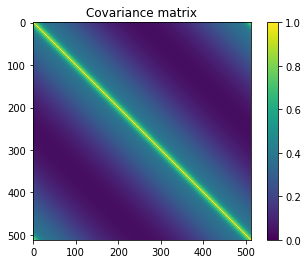

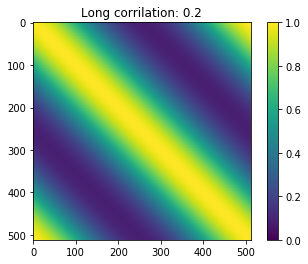

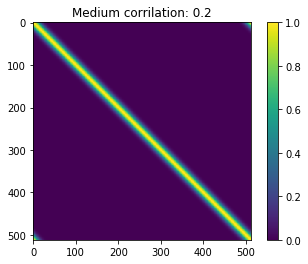

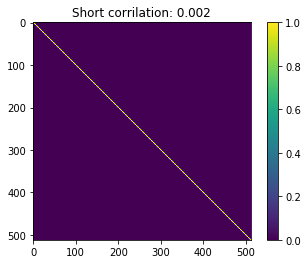

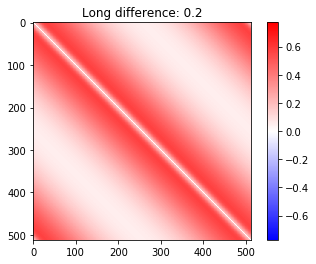

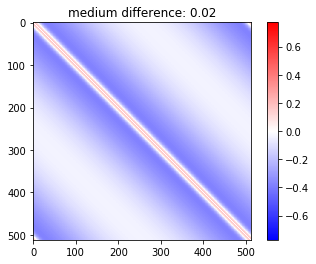

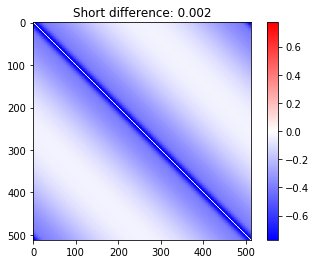

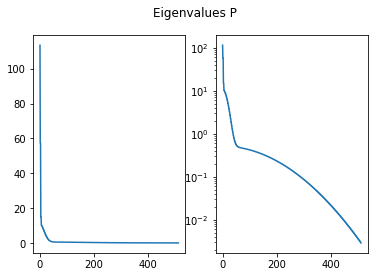

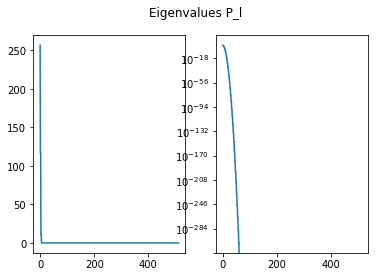

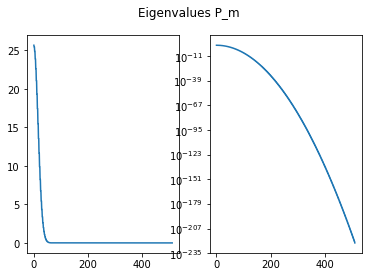

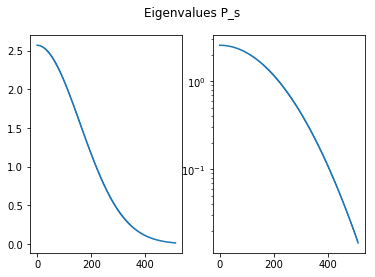

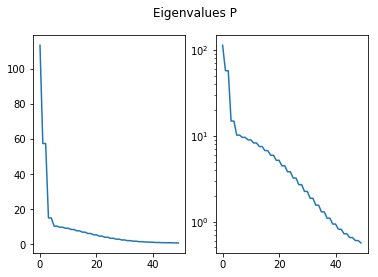

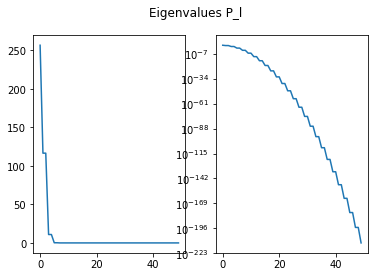

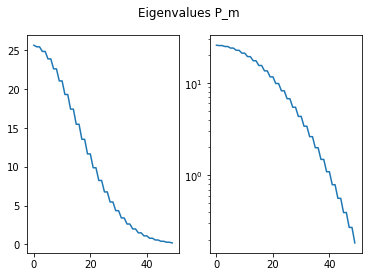

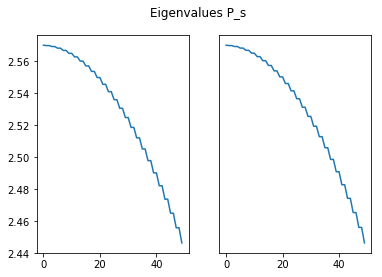

In [7]:
imshow(P, title='Covariance matrix', vmin=0, vmax=1)
imshow(P_l, title=f'Long corrilation: {rho0_l}', vmin=0, vmax=1)
imshow(P_m, title=f'Medium corrilation: {rho0_l}', vmin=0, vmax=1)
imshow(P_s, title=f'Short corrilation: {rho0_s}', vmin=0, vmax=1)

error_l = P_l - P
error_m = P_m - P
error_s = P_s - P

vmax = np.max([np.abs(error_l).max(),
               np.abs(error_s).max(),
               np.abs(error_m).max()])

vmax = np.max([np.abs(error_l).max(),
               np.abs(error_s).max()])

imshow(error_l, title=f'Long difference: {rho0_l}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
imshow(error_m, title=f'medium difference: {rho0_m}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
imshow(error_s, title=f'Short difference: {rho0_s}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
print('Log10(condition): ',
      np.log10(np.linalg.cond(P)))

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val)
ax[1].semilogy(eig_val)
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l)
ax[1].semilogy(eig_val_l)
plt.suptitle('Eigenvalues P_l')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_m)
ax[1].semilogy(eig_val_m)
plt.suptitle('Eigenvalues P_m')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s)
ax[1].semilogy(eig_val_s)
plt.suptitle('Eigenvalues P_s')

plot_sig_num = 50
fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val[:plot_sig_num])
ax[1].semilogy(eig_val[:plot_sig_num])
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l[:plot_sig_num])
ax[1].semilogy(eig_val_l[:plot_sig_num])
plt.suptitle('Eigenvalues P_l')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_m[:plot_sig_num])
ax[1].semilogy(eig_val_m[:plot_sig_num])
plt.suptitle('Eigenvalues P_m')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s[:plot_sig_num])
ax[1].semilogy(eig_val_s[:plot_sig_num])
plt.suptitle('Eigenvalues P_s')

# R^{-1/2} H P^{1/2} = U S VT

In [8]:
trans_mats = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    print(key)
    exec(key + '=val')

P_sqrt
P_inv_sqrt
R_sqrt
R_inv_sqrt
U
S
VT
H
Tx
Tx_inv
Ty
Ty_inv


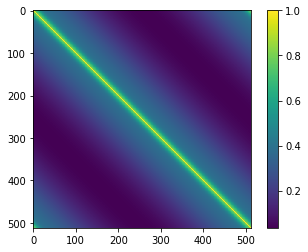

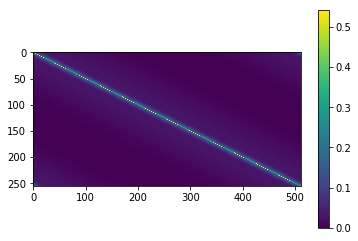

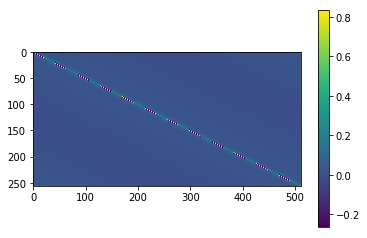

In [9]:
imshow(P_sqrt @ P_sqrt)
imshow(H @ P_sqrt)
imshow(U @ S @ VT)

In [11]:
%matplotlib inline

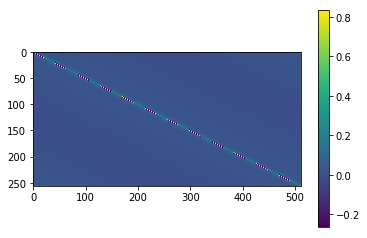

In [12]:
imshow(R_inv_sqrt @ H @ P_sqrt)

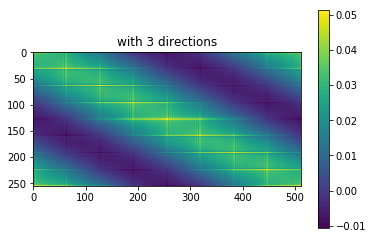

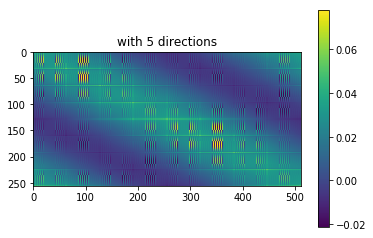

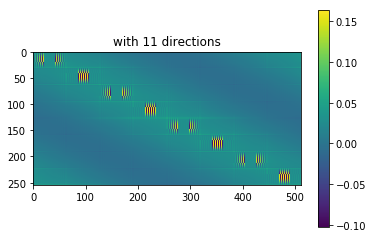

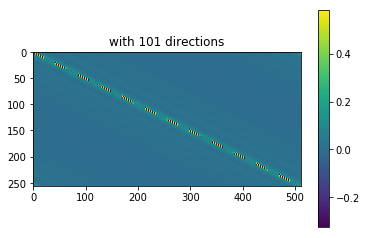

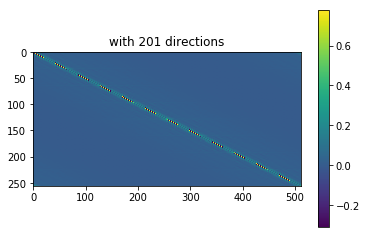

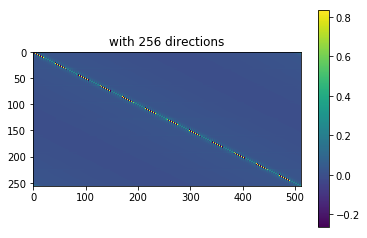

In [13]:
for sig_num in [3, 5, 11, 101, 201, 256]:
    imshow(U[:, :sig_num] @ S[:sig_num, :sig_num] @ VT[:sig_num],
           title=f'with {sig_num} directions')

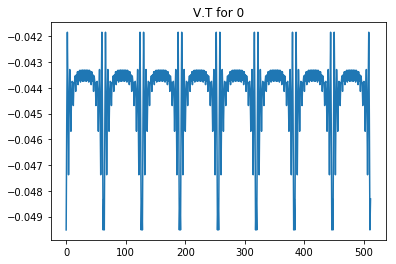

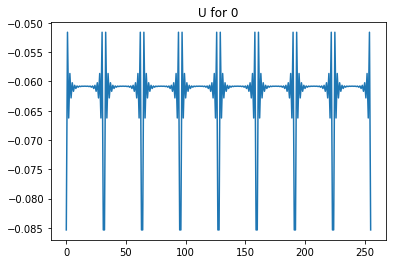

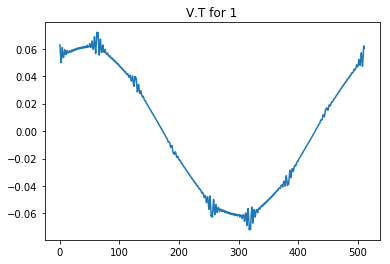

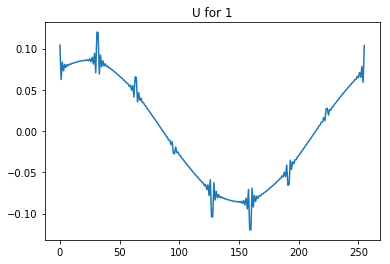

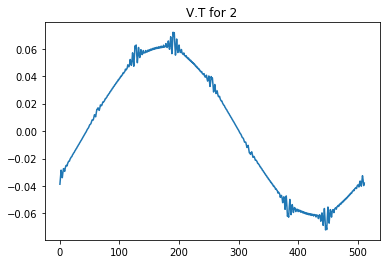

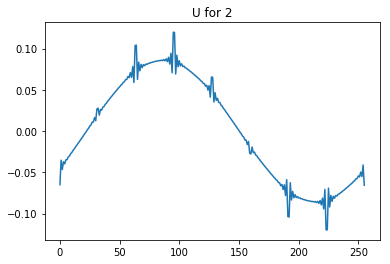

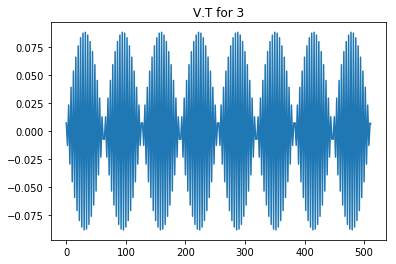

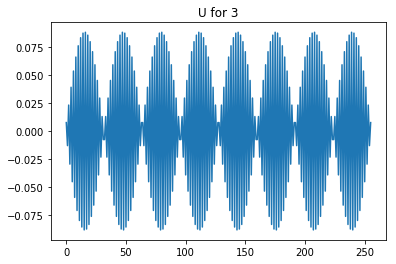

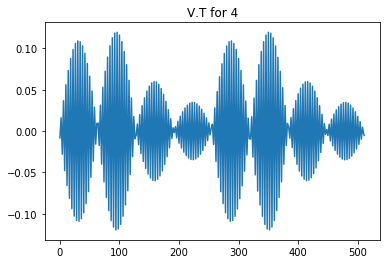

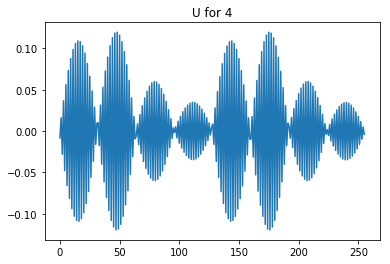

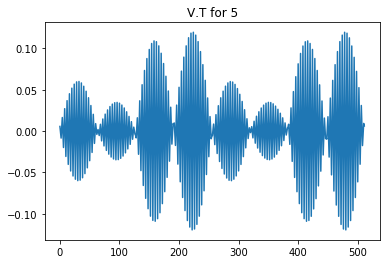

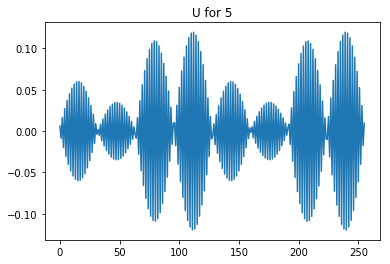

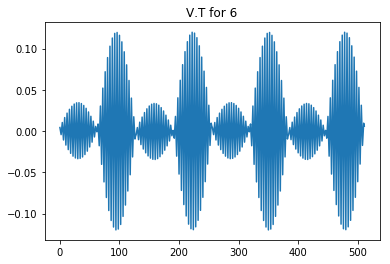

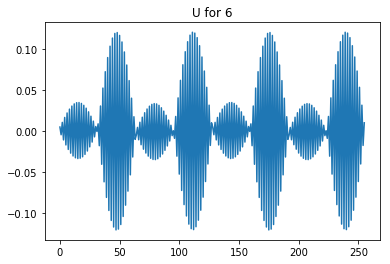

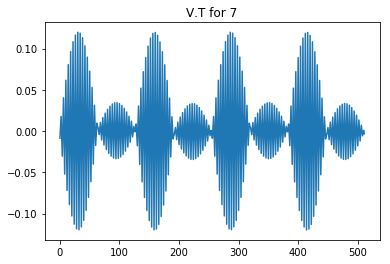

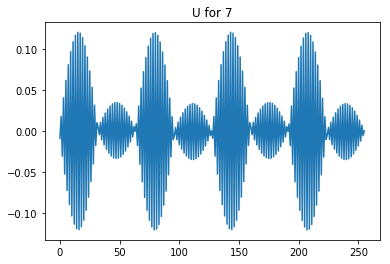

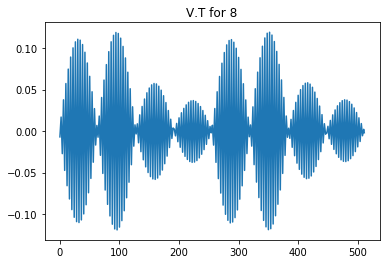

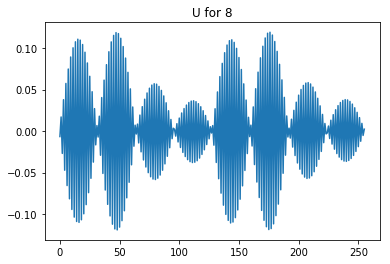

In [14]:
for ii in range(9):
    plt.figure()
    plt.plot(VT[ii])
    plt.title(f'V.T for {ii}')
    
    plt.figure()
    plt.plot(U[:, ii])
    plt.title(f'U for {ii}')

In [22]:
coarse_ens_size = 500
X_large = assimilate.generate_ensemble(ens_size=coarse_ens_size,
                                       mu=np.zeros(dimension),
                                       eig_val=eig_val,
                                       eig_vec=eig_vec
                                       )
P_sample_large = np.cov(X_large)

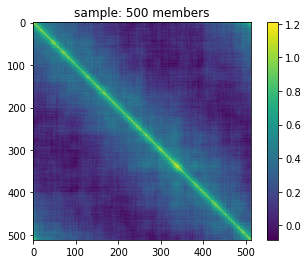

In [23]:
imshow(P_sample_large, title=f'sample: {coarse_ens_size} members')

In [24]:
subnum = 16
X_subgrid = X_large.reshape(dimension // subnum, subnum, coarse_ens_size)
X_subgrid = X_subgrid.mean(axis=1)
P_sample_subgrid = np.cov(X_subgrid)

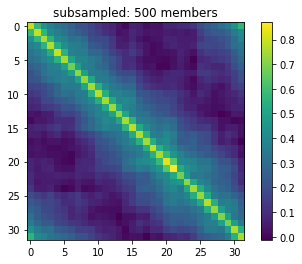

In [37]:
imshow(P_sample_subgrid, title=f'subsampled: {coarse_ens_size} members')

In [28]:
x_interp = np.arange(dimension)
x_data = x_interp.reshape(int(dimension/subnum), subnum).mean(axis=1)
x_data = np.concatenate([[x_data[0] - subnum],
                         x_data,
                         [x_data[-1] + subnum]])

In [29]:
X_subgrid_data = np.concatenate([X_subgrid[-1][None, :],
                                 X_subgrid,
                                 X_subgrid[0][None, :]],
                                axis=0)

In [30]:
interp_kind = 'cubic'
X_large_interp_fun = interpolate.interp1d(x_data, X_subgrid_data, kind=interp_kind, axis=0)

In [31]:
X_large_interp = X_large_interp_fun(x_interp)

In [33]:
eig_vec_interp, eig_val_interp, VT_interp = np.linalg.svd(X_large_interp, full_matrices=True)
eig_val_interp = eig_val_interp**2/(coarse_ens_size - 1)

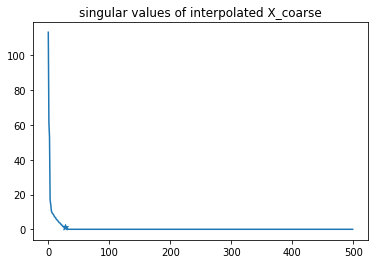

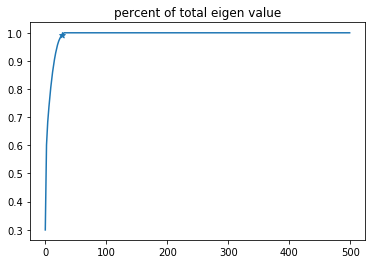

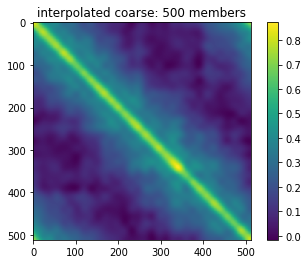

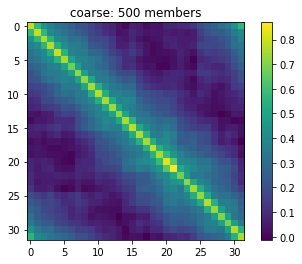

In [38]:
total_val = eig_val_interp.sum()
cumsum_val = eig_val_interp.cumsum()
max_val = .99
arg_val = np.argmin(np.abs(cumsum_val - max_val*total_val))

plt.figure()
plt.plot(eig_val_interp)
plt.scatter(arg_val, eig_val_interp[arg_val], marker='*')
plt.title('singular values of interpolated X_coarse')


plt.figure()
plt.plot(cumsum_val/total_val)
plt.scatter(arg_val, cumsum_val[arg_val]/total_val, marker='*')
plt.title('percent of total eigen value')

P_coarse_interp = (eig_vec_interp[:, :arg_val] 
                   @ np.diag(eig_val_interp[:arg_val])
                   @ eig_vec_interp[:, :arg_val].T)

imshow(P_coarse_interp,
       title=f'interpolated coarse: {coarse_ens_size} members')
imshow(P_sample_subgrid,
       title=f'coarse: {coarse_ens_size} members')

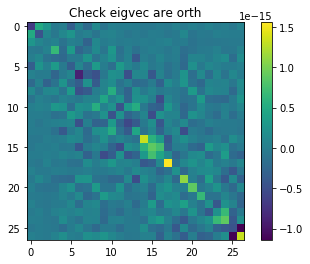

In [40]:
imshow(eig_vec_interp[:, :arg_val].T
       @ eig_vec_interp[:, :arg_val] - np.eye(arg_val),
       title='Check eigvec are orth')

/home/travis/miniconda3/envs/loc/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


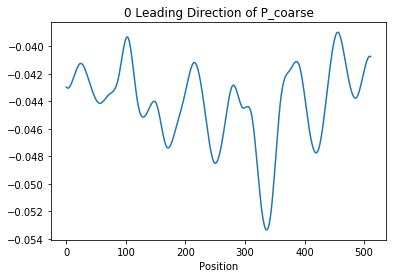

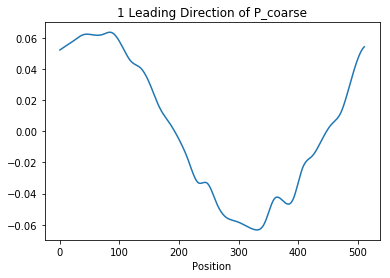

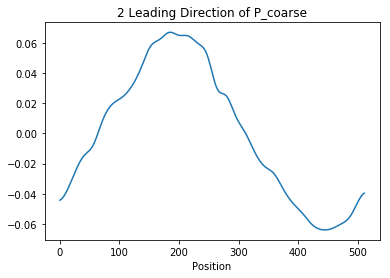

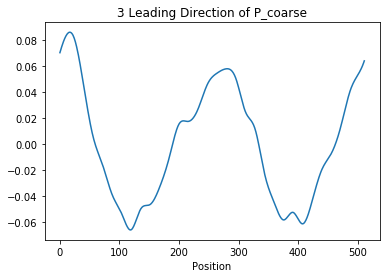

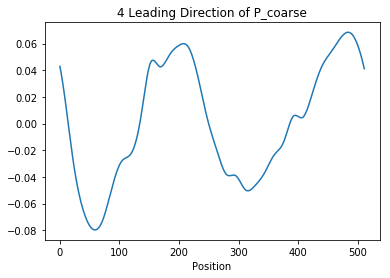

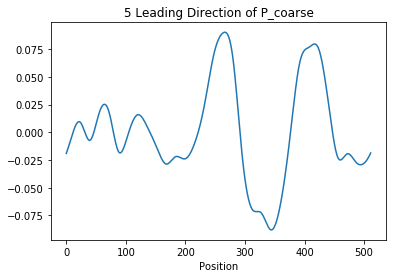

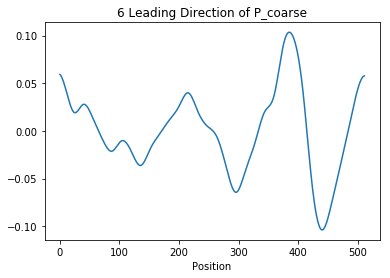

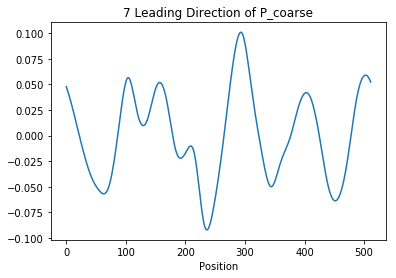

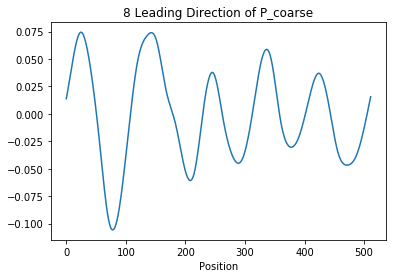

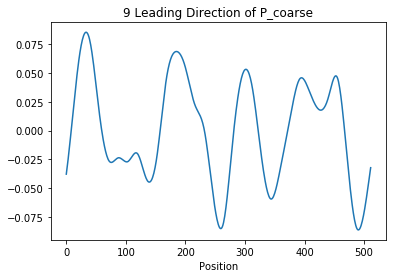

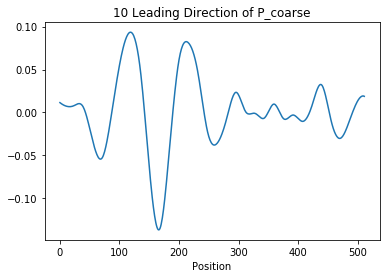

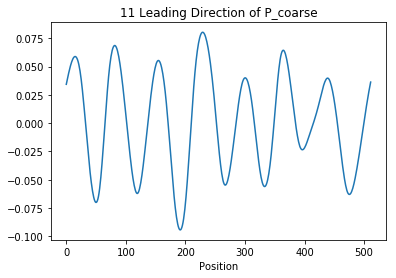

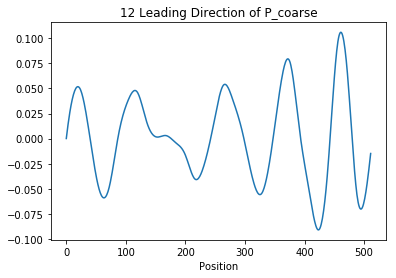

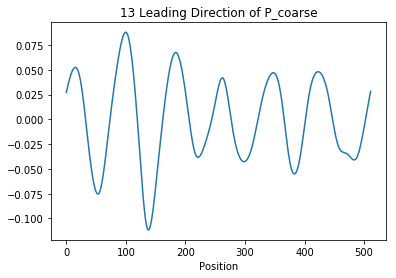

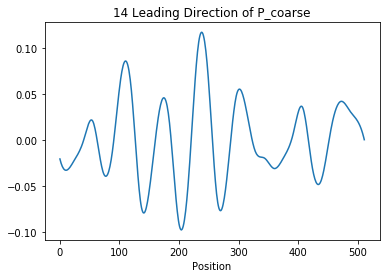

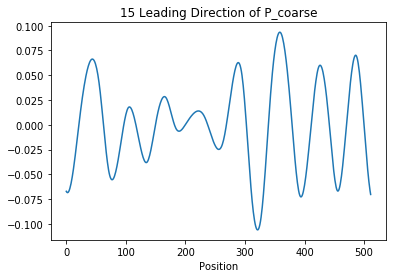

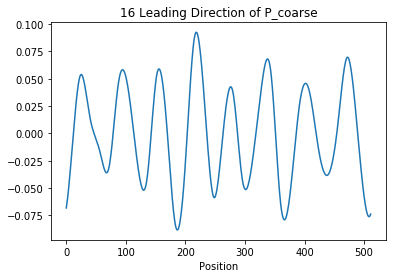

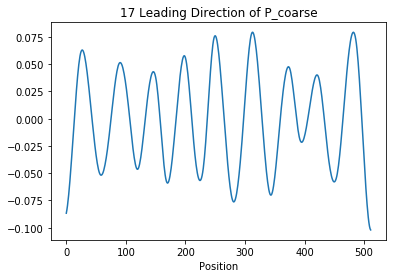

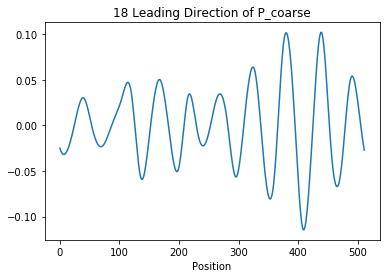

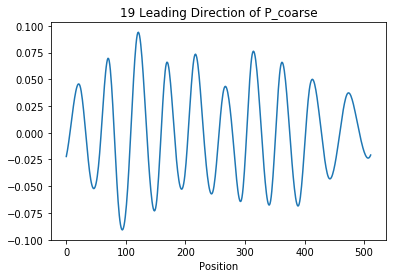

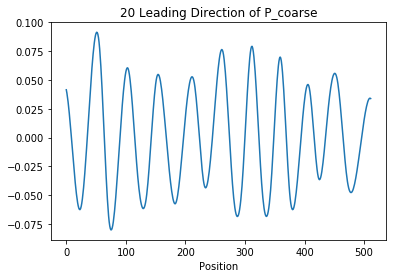

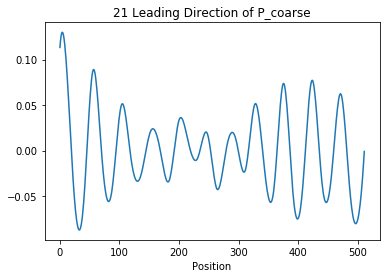

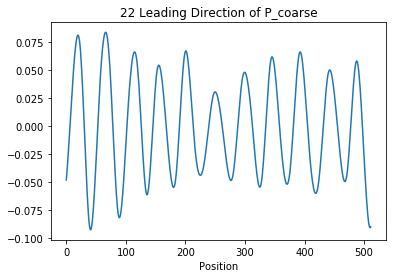

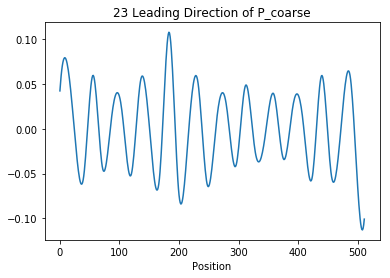

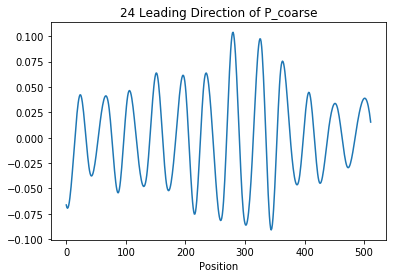

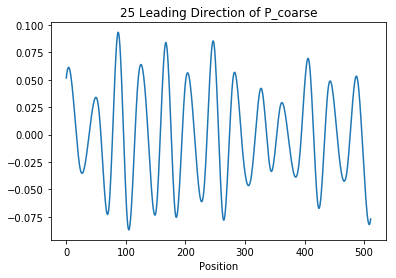

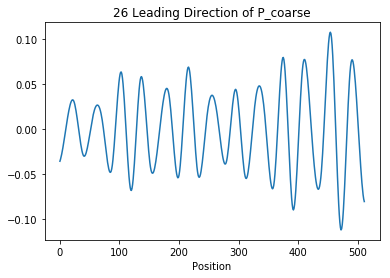

In [41]:
for ii in range(arg_val):
    plt.figure()
    plt.plot(eig_vec_interp[:, ii])
    plt.title(f'{ii} Leading Direction of P_coarse')
    plt.xlabel('Position')

In [43]:
P_sample_interp_sqrt = (
    eig_vec_interp[:, :arg_val]
    @ np.diag(np.sqrt(eig_val_interp[:arg_val]))
    @ eig_vec_interp[:, :arg_val].T)
P_sample_interp = (
    eig_vec_interp[:, :arg_val]
    @ np.diag(eig_val_interp[:arg_val])
    @ eig_vec_interp[:, :arg_val].T)

In [44]:
%matplotlib inline

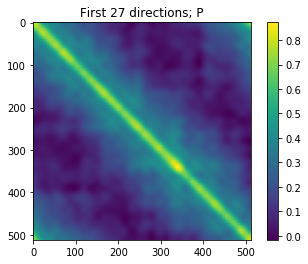

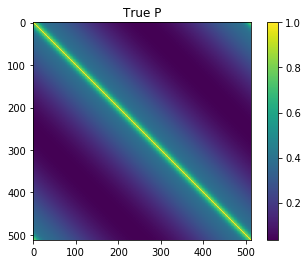

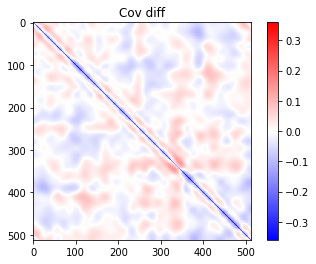

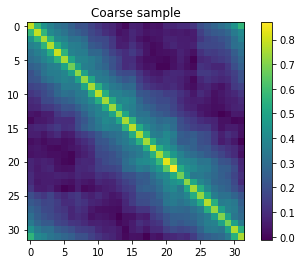

In [47]:
imshow(P_sample_interp, title=f'First {arg_val} directions; P')
imshow(P, title='True P')
P_diff = (P_sample_interp - P)
vmax = np.abs(P_diff).max()
imshow(P_diff,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title='Cov diff')
imshow(P_sample_subgrid, title='Coarse sample')

In [91]:
ens_size = 100
X = assimilate.generate_ensemble(ens_size=ens_size,
                                       mu=np.zeros(dimension),
                                       eig_val=eig_val,
                                       eig_vec=eig_vec
                                       )
P_sample = np.cov(X)

In [92]:
P_sample_til = (eig_vec_interp[:, :arg_val].T 
                @ P_sample 
                @ eig_vec_interp[:, :arg_val])
P_sample_coarse = (eig_vec_interp[:, :arg_val] 
                   @ np.diag(np.diag(P_sample_til))
                   @ eig_vec_interp[:, :arg_val].T)
# P_sample_coarse = (eig_vec_interp[:, :arg_val]
#                    @ eig_vec_interp[:, :arg_val].T 
#                    @ P_sample
#                    @ eig_vec_interp[:, :arg_val]
#                    @ eig_vec_interp[:, :arg_val].T)

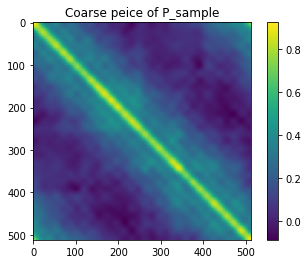

In [93]:
imshow(P_sample_coarse, 'Coarse peice of P_sample')

In [94]:
proj = (np.eye(dimension) - eig_vec_interp[:, :arg_val] @ eig_vec_interp[:, :arg_val].T)

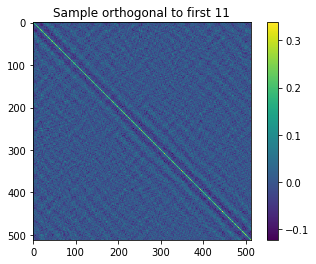

In [95]:
P_orth = proj @ P_sample @ proj
imshow(P_orth, 'Sample orthogonal to first 11')

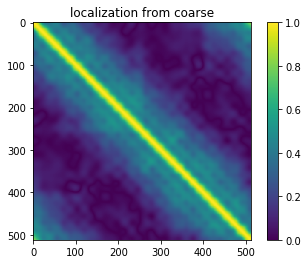

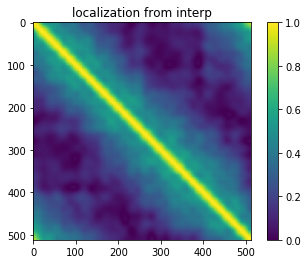

In [96]:
n = 1
P_n = (np.abs(P_sample_coarse)**n)
loc_coarse = np.diag(np.diag(1/np.sqrt(P_n))) @ P_n @ np.diag(np.diag(1/np.sqrt(P_n)))
imshow(loc_coarse, 'localization from coarse', vmin=0)

n = 1
P_n = (np.abs(P_coarse_interp)**n)
loc_interp = np.diag(np.diag(1/np.sqrt(P_n))) @ P_n @ np.diag(np.diag(1/np.sqrt(P_n)))
imshow(loc_interp, 'localization from interp', vmin=0)

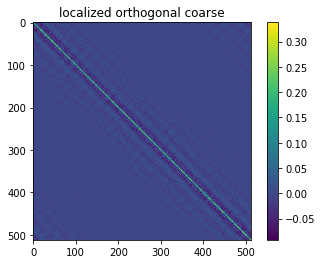

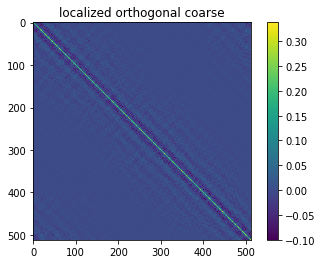

In [97]:
imshow(loc_coarse * P_orth, title='localized orthogonal coarse')

imshow(loc_interp * P_orth, title='localized orthogonal coarse')

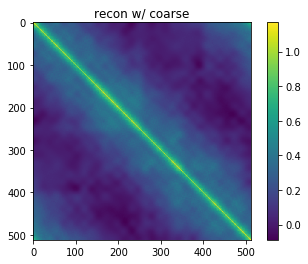

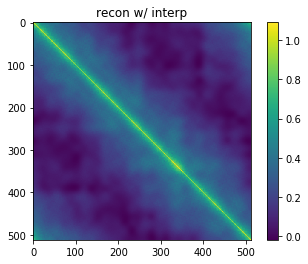

In [98]:
P_loc_coarse = P_sample_coarse + loc_coarse * P_orth
P_loc_interp = P_coarse_interp + loc_interp * P_orth

imshow(P_loc_coarse, title='recon w/ coarse')
imshow(P_loc_interp, title='recon w/ interp')

In [106]:
def check_cov_mats(P_true, Ps):
    vmax = np.max(
        [Ps[ii].max() for ii in Ps.keys()])
    vmax = np.max([P_true.max(), vmax])
    vmin = np.min(
        [Ps[ii].min() for ii in Ps.keys()])
    vmin = np.min([P_true.min(), vmin])
    imshow(P_true, vmax=vmax, vmin=vmin,
           title='True P')
    for key, item in Ps.items():
        imshow(item, vmax=vmax, vmin=vmin,
               title=key)
    errors = {key: aP - P_true for (key, aP) in Ps.items()}
    fro_norms = {
        key: np.round(
            np.linalg.norm(errors[key], ord='fro'),
            decimals=2) for key in errors.keys()}

    vmax = np.max(
        [np.abs(errors[key]).max() for key in errors.keys()])
    for key, item in errors.items():
        imshow(item, vmax=vmax, vmin=-vmax, cmap='bwr',
               title=key + f'; fro: {fro_norms[key]}')

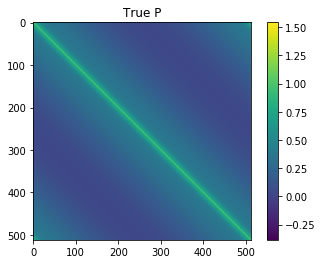

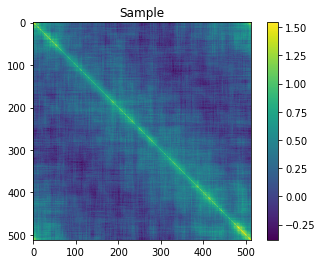

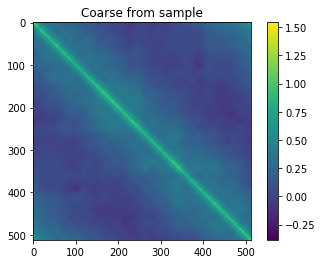

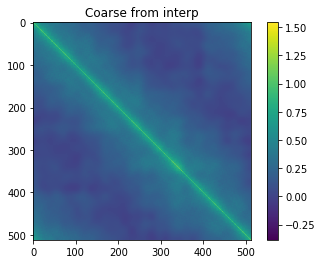

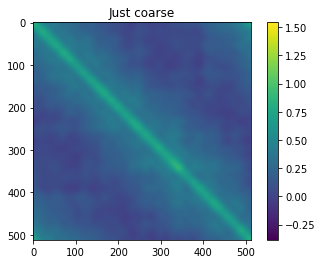

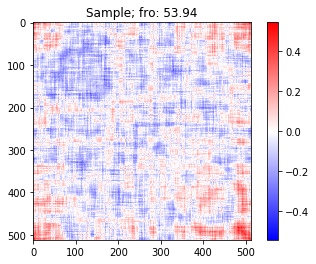

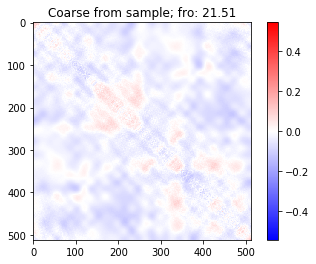

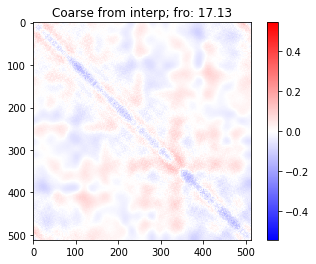

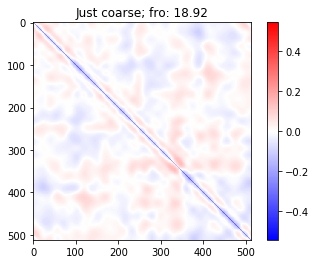

In [107]:
Ps_dict = {'Sample': P_sample, 
           'Coarse from sample': P_loc_coarse,
           'Coarse from interp': P_loc_interp,
           'Just coarse': P_coarse_interp}
check_cov_mats(P, Ps_dict)

In [ ]:
imshow(proj @ P_sample @ proj)

In [ ]:
subgrid_dim = P_sample_subgrid.shape[0]
imshow(P_sample_til)

In [ ]:
rho = np.arange(subgrid_dim)[None, :]
rho = np.abs(rho - rho.T)
rho0 = .5
loc = covariance.correlation_sqd_exp(rho=rho, rho0=rho0)

In [ ]:
P_sample_til_loc = P_sample_til * loc

In [ ]:
imshow(P_sample_til_loc)

In [ ]:
# P_sample_loc = P_sqrt @ VT_subgrid_interp.T @ P_sample_til_loc @ VT_subgrid_interp @ P_sqrt
P_sample_loc = VT_subgrid_interp.T @ P_sample_til_loc @ VT_subgrid_interp

In [ ]:
imshow(P_sample)

In [ ]:
imshow(P_sample_interp)

In [ ]:
imshow(P_sample_loc)

In [ ]:
imshow(P)

In [ ]:
imshow(proj)

In [ ]:
S_subgrid.shape

In [ ]:
VT_subgrid_interp.shape

In [ ]:
U_subgrid_interp.shape

In [ ]:
P_sample_interp.shape

In [ ]:
X_til = VT @ P_inv_sqrt @ X
P_sample_til = np.cov(X_til)

rho_smooth = 100
X_smooth = ndimage.gaussian_filter1d(X, sigma=rho_smooth, mode='wrap', axis=0)
X_til_smooth = VT @ P_inv_sqrt @ X_smooth
P_sample_til_smooth = np.cov(X_til_smooth)

In [ ]:
plt.figure()
plt.plot(X[:, 0])

plt.figure()
plt.plot(X_smooth[:, 0])

In [ ]:
imshow(P_sample_til)
imshow(P_sample_til_smooth)

In [ ]:
rho = np.arange(dimension)[None, :]
rho = np.abs(rho - rho.T)

In [ ]:
imshow(rho)

In [ ]:
rho0 = 5
loc = covariance.correlation_sqd_exp(rho=rho, rho0=rho0)

In [ ]:
P_sample_til_loc_smooth = loc * P_sample_til_smooth
# P_sample_til_loc_smooth = np.diag(np.diag(P_sample_til_loc_smooth))
P_sample_til_loc = loc * P_sample_til
# P_sample_til_loc = np.diag(np.diag(P_sample_til))

In [ ]:
imshow(P_sample_til)
imshow(P_sample_til_smooth)
# imshow(loc)
imshow(P_sample_til_loc)
imshow(P_sample_til_loc_smooth)

In [ ]:
# P_sample_til_loc_sqrt = np.real(covariance.matrix_sqrt(C=P_sample_til_loc))
# P_sample_til_loc_sqrt_smooth = np.real(covariance.matrix_sqrt(C=P_sample_til_loc_smooth))

In [ ]:
# X_til_loc = assimilate.generate_ensemble(ens_size=ens_size*1000,
#                                          mu=np.zeros(dimension),
#                                          P_sqrt=P_sample_til_loc_sqrt)

In [ ]:
# X_loc = P_sqrt @ VT.T @ X_til_loc

In [ ]:
# imshow(P_sample_til_loc)

In [ ]:
# P_sample_loc = np.cov(X_loc)

In [ ]:
P_sample_loc = P_sqrt @ VT.T @ P_sample_til_loc @ VT @ P_sqrt
P_sample_loc_smooth = P_sqrt @ VT.T @ P_sample_til_loc_smooth @ VT @ P_sqrt

In [ ]:
imshow(P_sample)
imshow(P_sample_loc)
imshow(P_sample_loc_smooth)
imshow(0.5*(P_sample_loc + 3.5*P_sample_loc_smooth))
imshow(P)

In [ ]:
err_loc_smooth = P - P_sample_loc_smooth
L2_loc_smooth = np.linalg.norm(err_loc_smooth, ord=2)
err_loc = P - P_sample_loc
L2_loc = np.linalg.norm(err_loc, ord=2)
err = P - P_sample
L2 = np.linalg.norm(err, ord=2)
vmax = np.max(
    [np.abs(err_loc_smooth).max(),
     np.abs(err_loc).max(),
     np.abs(err).max()])
imshow(err_loc_smooth,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Localized error; L2: {L2_loc_smooth}')
imshow(err_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Localized error; L2: {L2_loc}')
imshow(err,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Unlocalized error; L2: {L2}')